In [164]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from os import listdir
from os.path import isfile, join
from PIL import Image
import pickle
from tensorflow.keras import backend as K

In [165]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

def load_data():
    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

    def get_tuple_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber: ].astype('float32') # opt_band is in target
        return X, Y

    df = pd.read_csv(DATASET_PATH)
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

In [166]:
train_dataset, val_dataset, test_dataset = load_data()

In [167]:
def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def processDataToImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = 255.0
    img = Image.fromarray(data, 'L')
    resized = img.resize((32, 32), Image.NEAREST)
    image = np.array(resized, dtype=np.float32)
    image = np.reshape(image, (32, 32, 1))
    return image

def processImageOutput(graphInput, nodelist):
    adj = getGraph(graphInput)
    Graph = nx.Graph(adj)
    adj = nx.adjacency_matrix(Graph, nodelist=nodelist)

    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w), dtype=np.uint8)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if adj[i, j] == 1:
                data[i, j] = 255.0
    img = Image.fromarray(data, 'L')
    resized = img.resize((32, 32), Image.NEAREST)
    image = np.array(resized, dtype=np.float32)
    image = np.reshape(image, (32, 32, 1))
    return image

In [168]:
def getData_2(dataset):
    train_x = []
    train_output = []
    for graphInput, target in dataset:
        nodelist = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_x.append(x_image)
        y_image = processImageOutput(graphInput, nodelist)
        train_output.append(y_image)
    return np.array(train_x), np.array(train_output)

In [169]:
train_x, train_y = getData_2(train_dataset)
val_x, val_y= getData_2(val_dataset)
test_x, test_y = getData_2(test_dataset)

print(train_x.shape)
print(train_y.shape)

(835, 32, 32, 1)
(835, 32, 32, 1)


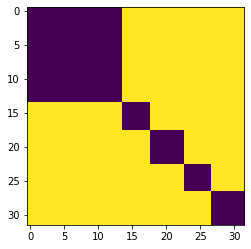

<Figure size 432x288 with 0 Axes>

In [170]:
plt.imshow(train_x[0])
plt.show()
plt.clf()


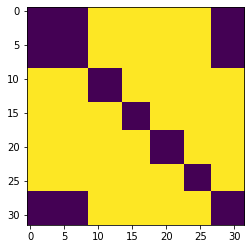

In [171]:
plt.imshow(train_y[0])

In [172]:
examples = train_x[0:2]
examples_y = train_y[0:2]
print(examples.shape)

rescaling = layers.Rescaling(1./255)
pred = layers.Conv2D(1, 3, padding='same', activation='relu', input_shape=(32, 32))(rescaling(examples))
print(pred.shape)

print(examples[0].dtype)
print(pred[0].dtype)
print(examples_y[0].dtype)

(2, 32, 32, 1)
(2, 32, 32, 1)
float32
<dtype: 'float32'>
float32


In [179]:
def frobeniusLoss(y_true, y_pred):
  error = y_true - y_pred
  size = tf.size(error)
  return tf.norm(error, ord='fro',axis=(0,1)) / tf.cast(size, tf.float32)

# LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def pix2pixLoss(true, pred):
  # gan_loss = loss_object(tf.ones_like(pred), pred)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(true - pred))
  # loss = gan_loss + (LAMBDA * l1_loss)
  # loss = LAMBDA * l1_loss
  loss = l1_loss
  # fro = frobeniusLoss(true, pred)
  # return loss + fro
  return loss

# feito somente mae, 256 epochs (output_channel - 1) = saida interessante
# feito somente fro, 256 epochs (output_channel - 1) = saída nada interessante
# feito mae + fro, 256 epochs (output_channel - 1) = mais ou menos interessante
# feito somente mae, 8 epochs (output_channel - 3), 7 nodes = MUITO INTERESSANTE
# feito somente mae com BinaryCrossentropy, 8 epochs (output_channel - 3), 7 nodes = mais ou menos interessante
# feito somente mae, 32 epochs (output_channel - 3), 7 nodes = MUITO INTERESSANTE, mas as saidas sao bem parecidas (cantos pretos)
# feito somente mae, 32 epochs (output_channel - 1), 7 nodes = resultado muito parecido com o anterior (só q o anterior é 3 channels)
# fazendo somente mae, 16 epochs (output_channel - 1), 7 nodes, sem lambda = resultado muito parecido com o anterior
# a fazer somente frobenius, 32 epochs (output_channel - 1), 7 nodes = resultado parecido com anterior, mas o meio nao fica bem definido

In [187]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256, 256, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

initializer = tf.random_normal_initializer(0., 0.02)
model = tf.keras.models.Sequential([
  layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2DTranspose(512, 4,  strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.ReLU(),
  # tf.keras.layers.Conv2DTranspose(512, 4,  strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Dropout(0.5),
  # tf.keras.layers.ReLU(),
  # tf.keras.layers.Conv2DTranspose(512, 4,  strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Dropout(0.5),
  # tf.keras.layers.ReLU(),
  # tf.keras.layers.Conv2DTranspose(512, 4,  strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2DTranspose(256, 4,  strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2DTranspose(128, 4,  strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2DTranspose(64, 4,  strides=2, padding='same', kernel_initializer=initializer, use_bias=False),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
])

model.compile(optimizer='adam',
              loss=frobeniusLoss,
              # loss=pix2pixLoss,
              # loss='mse',
              metrics=['accuracy'])

history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=32,
)

Epoch 1/32
27/27 [==============================] - 138s 5s/step - loss: 0.1610 - accuracy: 0.2601 - val_loss: 0.1680 - val_accuracy: 0.5734
Epoch 2/32
27/27 [==============================] - 131s 5s/step - loss: 0.1610 - accuracy: 0.0180 - val_loss: 0.1679 - val_accuracy: 0.5734
Epoch 3/32
27/27 [==============================] - 131s 5s/step - loss: 0.1609 - accuracy: 0.0149 - val_loss: 0.1679 - val_accuracy: 0.5734
Epoch 4/32
27/27 [==============================] - 143s 5s/step - loss: 0.1608 - accuracy: 0.0191 - val_loss: 0.1678 - val_accuracy: 0.5734
Epoch 5/32
27/27 [==============================] - 138s 5s/step - loss: 0.1611 - accuracy: 0.0222 - val_loss: 0.1678 - val_accuracy: 0.5734
Epoch 6/32
27/27 [==============================] - 123s 5s/step - loss: 0.1609 - accuracy: 0.0265 - val_loss: 0.1678 - val_accuracy: 0.5734
Epoch 7/32
27/27 [==============================] - 121s 4s/step - loss: 0.1609 - accuracy: 0.0370 - val_loss: 0.1678 - val_accuracy: 0.5734
Epoch 8/32
27

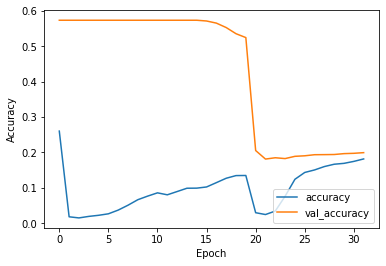

In [188]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

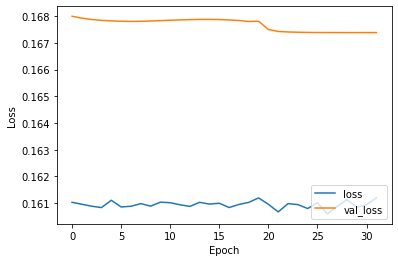

In [189]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [190]:
# test = np.array([test_images[0]])
pred = model.predict(test_x)
true = test_y
# print(pred)
print("Pred")
print(pred.shape)
print("True")
print(true.shape)

Pred
(63, 32, 32, 1)
True
(63, 32, 32, 1)


Entry 30


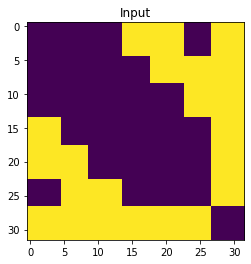

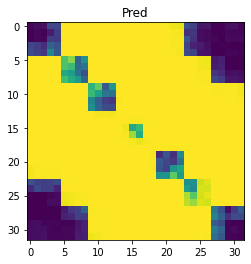

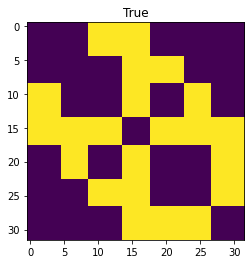

Entry 31


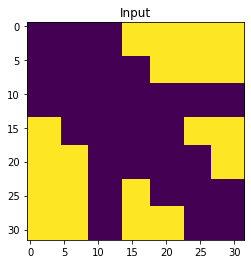

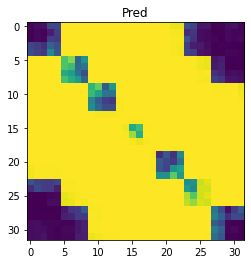

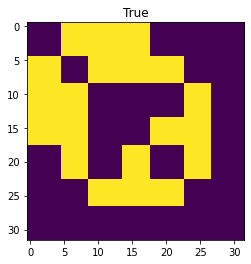

Entry 32


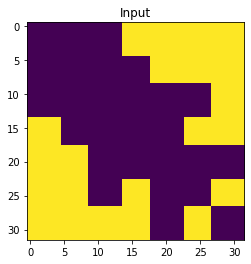

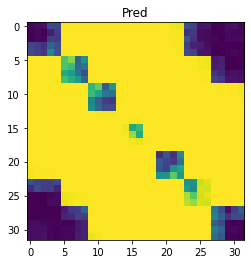

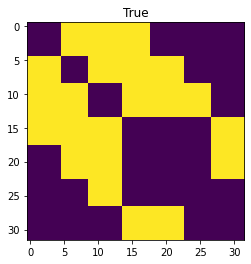

In [191]:
for i in range(30, 33):
  print("Entry", i)
  plt.title("Input")
  plt.imshow(test_x[i])
  plt.show()

  plt.title("Pred")
  plt.imshow(pred[i])
  plt.show()

  plt.title("True")
  plt.imshow(test_y[i])
  plt.show()